# Modellierung & Dashboard-Vorbereitung

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import shap

import xgboost as xgb

In [2]:
df = pd.read_csv("../candy-data.csv")

In [3]:
X = df.drop(columns=['competitorname', 'winpercent'])
y = df['winpercent']

### Linear Regression

In [4]:
X_ols = X.copy()

X_ols = sm.add_constant(X_ols)

ols_model = sm.OLS(y, X_ols).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             winpercent   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     7.797
Date:                Fri, 04 Jul 2025   Prob (F-statistic):           9.50e-09
Time:                        13:31:23   Log-Likelihood:                -315.64
No. Observations:                  85   AIC:                             655.3
Df Residuals:                      73   BIC:                             684.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               34.5340      4.320  

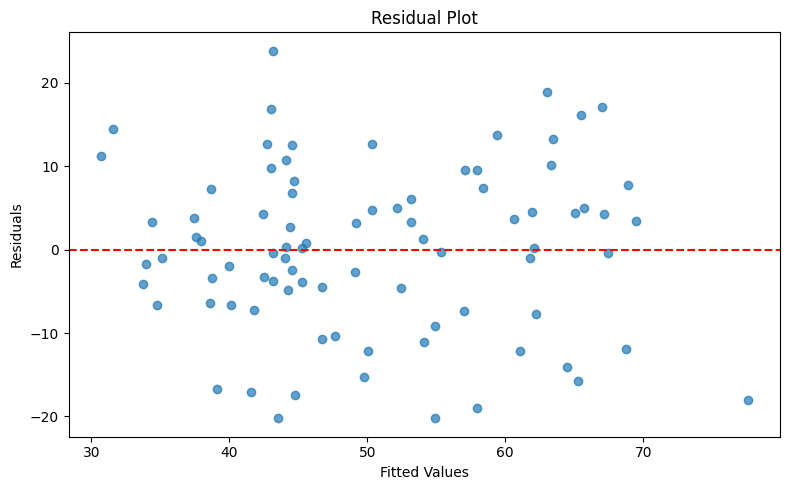

In [5]:
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

plt.figure(figsize=(8, 5))
plt.scatter(fitted_vals, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

In [6]:
# Breusch-Pagan-Test to check Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals, X_ols)

labels = ['LM Statistic', 'LM p-value', 'F-statistic', 'F p-value']
for label, value in zip(labels, bp_test):
    print(f"{label}: {value:.4f}")

LM Statistic: 14.5163
LM p-value: 0.2057
F-statistic: 1.3668
F p-value: 0.2071


### Decision Tree 
No tuning, for demonstration purposes only.

R² scores (5-fold): [-0.03014946  0.12963427  0.18856273  0.14431306 -0.27084328]
Average R²: 0.032303466169463335
RMSE scores (5-fold): [154.76386726 139.58170888 153.36445726 242.32230172 204.17220339]
Average RMSE: 178.84090770221866


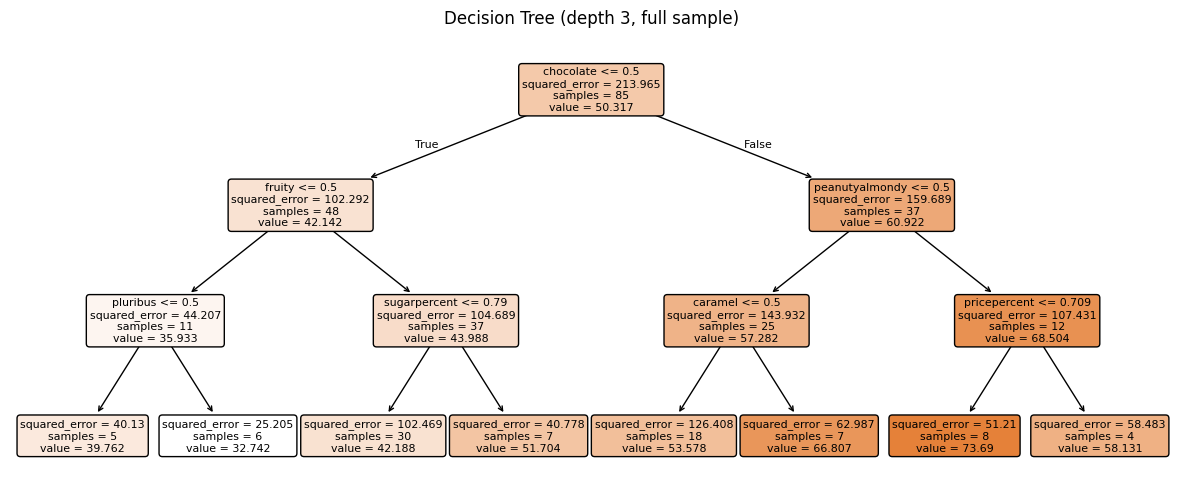

In [7]:
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_results = cross_validate(
    tree_model,
    X,
    y,
    cv=5,
    scoring={'r2': 'r2', 'rmse': rmse_scorer},
    return_train_score=False
)

print("R² scores (5-fold):", cv_results['test_r2'])
print("Average R²:", np.mean(cv_results['test_r2']))
print("RMSE scores (5-fold):", -cv_results['test_rmse'])
print("Average RMSE:", -np.mean(cv_results['test_rmse']))

tree_model.fit(X, y)
plt.figure(figsize=(15, 6))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree (depth 3, full sample)")
plt.show()

### XGBOOST

Best hyperparameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Cross-validated R² scores: [0.271 0.421 0.46  0.387 0.428]
Mean R²: 0.393
Cross-validated RMSE scores: [12.09  11.036 10.423  9.064 12.652]
Mean RMSE: 11.053


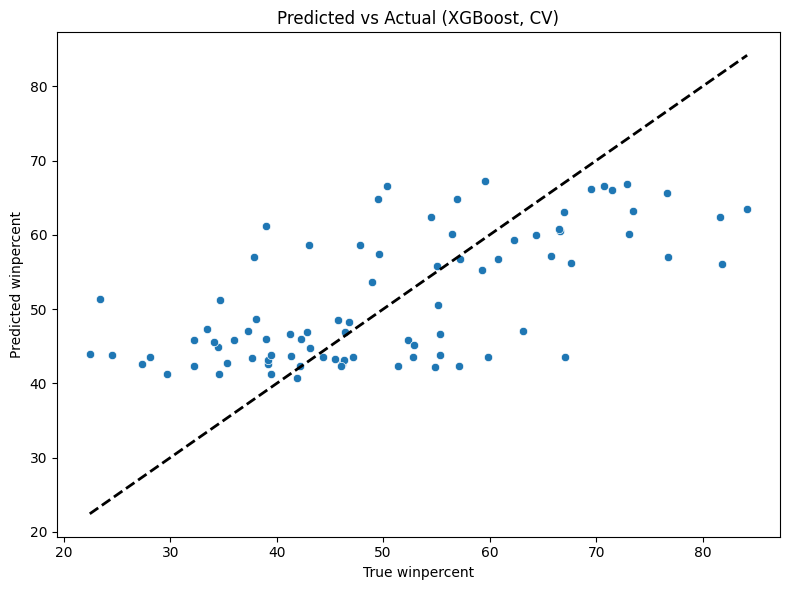

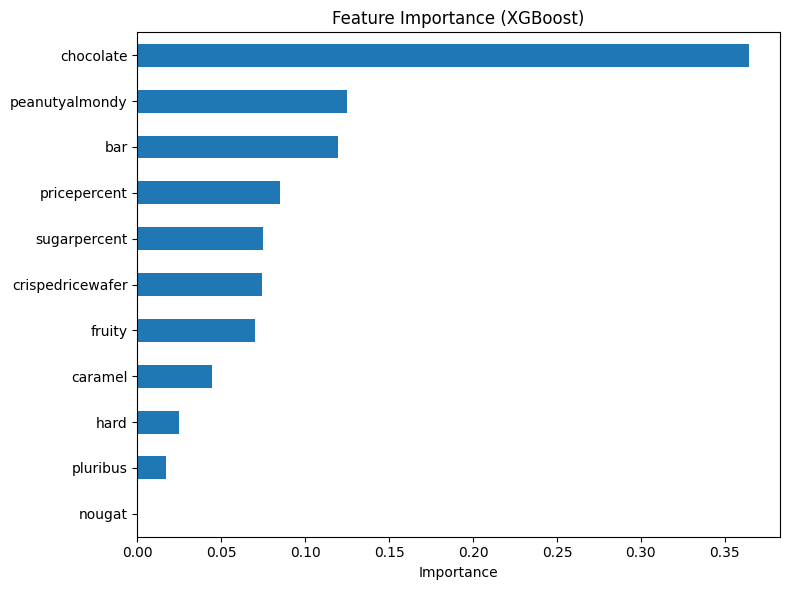

In [8]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.5, 1, 2]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='neg_root_mean_squared_error',
    n_iter=25,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)
best_model = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
neg_mse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=make_scorer(mean_squared_error))
rmse_scores = np.sqrt(neg_mse_scores)

print("\nCross-validated R² scores:", np.round(r2_scores, 3))
print("Mean R²: {:.3f}".format(np.mean(r2_scores)))
print("Cross-validated RMSE scores:", np.round(rmse_scores, 3))
print("Mean RMSE: {:.3f}".format(np.mean(rmse_scores)))

y_pred = cross_val_predict(best_model, X, y, cv=kf)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("True winpercent")
plt.ylabel("Predicted winpercent")
plt.title("Predicted vs Actual (XGBoost, CV)")
plt.tight_layout()
plt.show()

best_model.fit(X, y)

importances = best_model.feature_importances_
importances_series = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
importances_series.plot(kind='barh')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


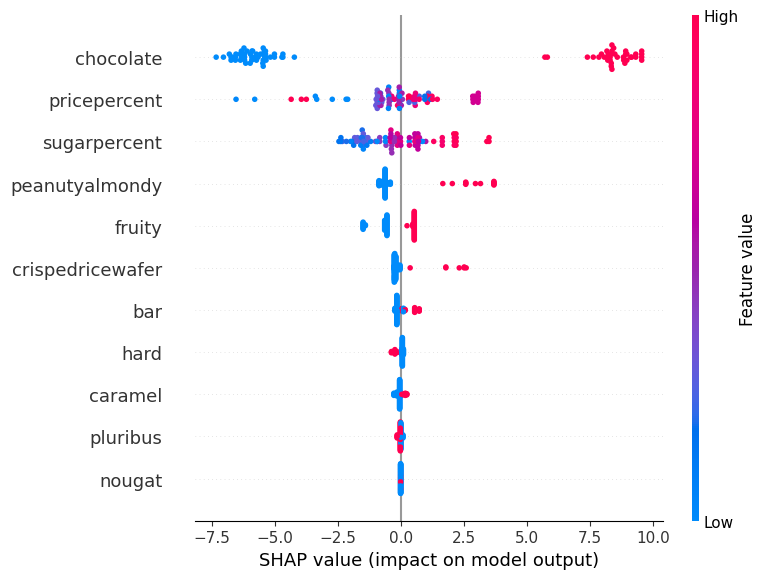

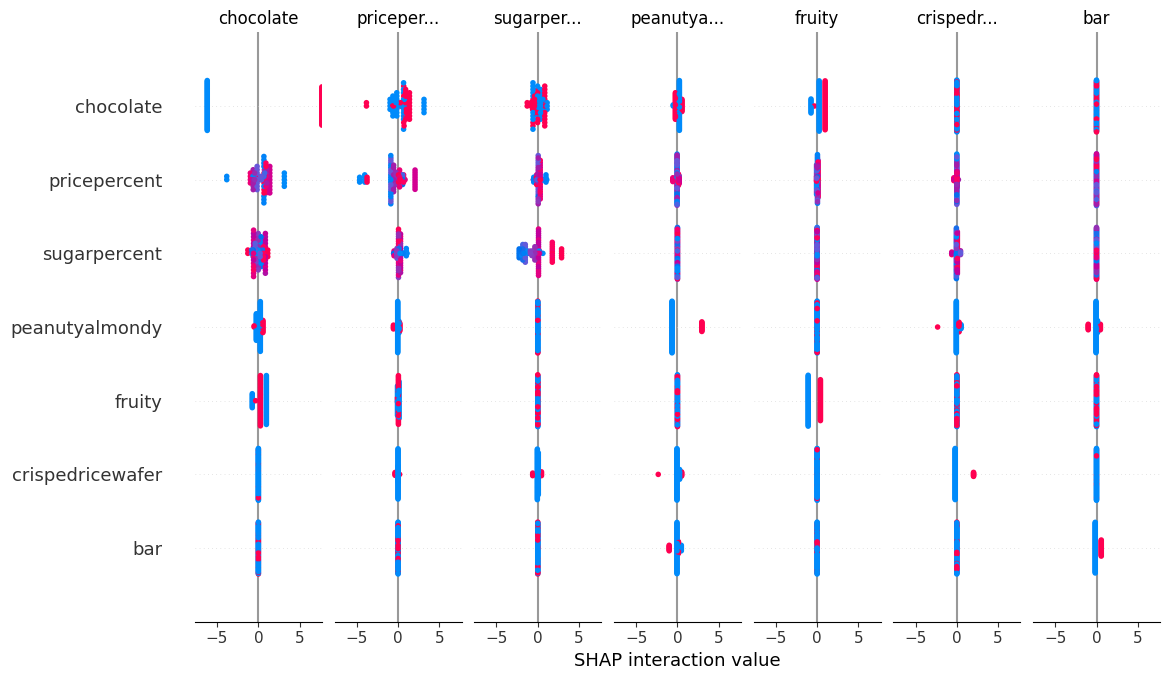

In [9]:
explainer_xgb = shap.Explainer(best_model)
shap_values_xgb = explainer_xgb(X)

shap.summary_plot(shap_values_xgb, X)

explainer_tree = shap.TreeExplainer(best_model)
shap_interactions = explainer_tree.shap_interaction_values(X)
shap.summary_plot(shap_interactions, X)

### Cluster Analysis

Number of clusters: 2, Silhouette Score: 0.3732
Number of clusters: 3, Silhouette Score: 0.3512
Number of clusters: 4, Silhouette Score: 0.3326
Number of clusters: 5, Silhouette Score: 0.4027


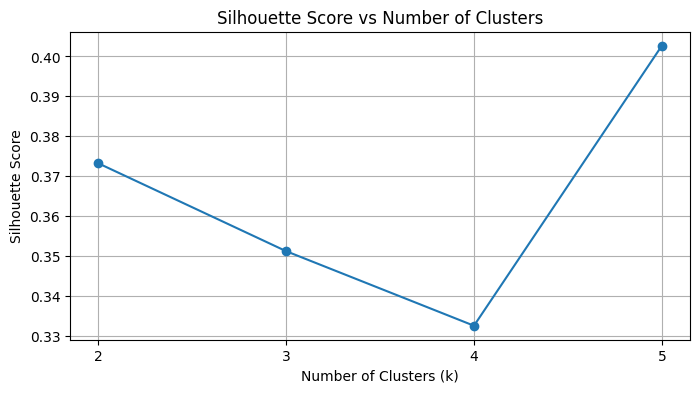


Optimal number of clusters: 5


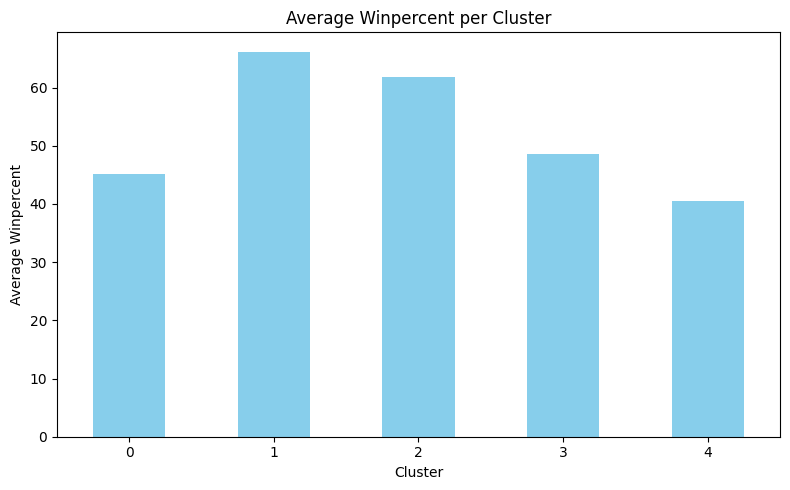


Cluster characteristics with sizes:


,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,size,avg_winpercent
cluster,,,,,,,,,,,
0,0.000,0.926,0.037,0.000,0.000,0.0,0.0,0.000,0.704,27,45.144483
1,1.000,0.000,0.429,0.143,0.000,1.0,0.0,0.857,0.143,7,66.170252
2,0.944,0.000,0.278,0.500,0.389,0.0,0.0,0.833,0.000,18,61.803915
3,0.667,0.000,0.222,0.222,0.000,0.0,0.0,0.000,0.889,18,48.595941
4,0.067,0.867,0.067,0.000,0.000,0.0,1.0,0.000,0.533,15,40.508982


In [10]:
features = df.drop(columns=['competitorname', 'winpercent', 'sugarpercent', 'pricepercent'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

sil_scores = []
cluster_range = range(2, 6)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"Number of clusters: {k}, Silhouette Score: {score:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

best_k = cluster_range[np.argmax(sil_scores)]
print(f"\nOptimal number of clusters: {best_k}")

kmeans_best = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans_best.fit_predict(X_scaled)

cluster_summary = df.groupby('cluster')['winpercent'].mean().sort_index()

plt.figure(figsize=(8, 5))
cluster_summary.plot(kind='bar', color='skyblue')
plt.title('Average Winpercent per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Winpercent')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

cluster_features = df.groupby('cluster')[features.columns].mean().round(3)

cluster_sizes = df['cluster'].value_counts().sort_index()

cluster_summary_df = cluster_features.copy()
cluster_summary_df['size'] = cluster_sizes

print("\nCluster characteristics with sizes:")
cluster_summary_df['avg_winpercent'] = cluster_summary
cluster_summary_df


### OLS with Interaction Terms
- Creating all possible interaction terms with chocolate
- using lasso to select only relevant features
- running ols on model with relevant features (including interactions)

In [11]:
X = df.drop(columns=['competitorname', 'winpercent', 'cluster', 'sugarpercent', 'pricepercent'])
y = df['winpercent']

chocolate = X[['chocolate']]
other_features = X.drop(columns='chocolate')

interactions = chocolate.values * other_features.values
interaction_df = pd.DataFrame(interactions, columns=[f'{col}_x_chocolate' for col in other_features.columns])

X_full = pd.concat([X, interaction_df], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

lasso = LassoCV(cv=5, max_iter=10000, random_state=42).fit(X_scaled, y)

selected_mask = lasso.coef_ != 0
selected_features = X_full.columns[selected_mask]

print("All features:")
print(X_full.columns)
print("Selected features by Lasso:")
print(selected_features)

X_selected = sm.add_constant(X_full[selected_features])
ols_model = sm.OLS(y, X_selected).fit()

print("\nFinal OLS model summary:")
print(ols_model.summary())


All features:
Index(['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat',
       'crispedricewafer', 'hard', 'bar', 'pluribus', 'fruity_x_chocolate',
       'caramel_x_chocolate', 'peanutyalmondy_x_chocolate',
       'nougat_x_chocolate', 'crispedricewafer_x_chocolate',
       'hard_x_chocolate', 'bar_x_chocolate', 'pluribus_x_chocolate'],
      dtype='object')
Selected features by Lasso:
Index(['chocolate', 'fruity', 'crispedricewafer', 'hard',
       'caramel_x_chocolate', 'peanutyalmondy_x_chocolate',
       'crispedricewafer_x_chocolate'],
      dtype='object')

Final OLS model summary:
                            OLS Regression Results                            
Dep. Variable:             winpercent   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     15.25
Date:                Fri, 04 Jul 2025   Prob (F-statistic):           1.78e-1

### Additional Analysis: Effects on Price and Sugar


In [12]:
targets = ["sugarpercent", "pricepercent"]
for target in targets:
    print(f"Target: {target}\n")
    X = df.drop(columns=['competitorname', 'winpercent']+targets)
    y = df[target]

    chocolate = X[['chocolate']]
    other_features = X.drop(columns='chocolate')

    interactions = chocolate.values * other_features.values
    interaction_df = pd.DataFrame(interactions, columns=[f'{col}_x_chocolate' for col in other_features.columns])

    X_full = pd.concat([X, interaction_df], axis=1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_full)

    lasso = LassoCV(cv=5, max_iter=10000, random_state=42).fit(X_scaled, y)

    selected_mask = lasso.coef_ != 0
    selected_features = X_full.columns[selected_mask]

    print("All features:")
    print(X_full.columns)
    print("Selected features by Lasso:")
    print(selected_features)

    X_selected = sm.add_constant(X_full[selected_features])
    ols_model = sm.OLS(y, X_selected).fit()

    print("\nFinal OLS model summary:")
    print(ols_model.summary())
    print("\n##### ##### #####\n")


Target: sugarpercent

All features:
Index(['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat',
       'crispedricewafer', 'hard', 'bar', 'pluribus', 'cluster',
       'fruity_x_chocolate', 'caramel_x_chocolate',
       'peanutyalmondy_x_chocolate', 'nougat_x_chocolate',
       'crispedricewafer_x_chocolate', 'hard_x_chocolate', 'bar_x_chocolate',
       'pluribus_x_chocolate', 'cluster_x_chocolate'],
      dtype='object')
Selected features by Lasso:
Index(['caramel', 'cluster', 'caramel_x_chocolate'], dtype='object')

Final OLS model summary:
                            OLS Regression Results                            
Dep. Variable:           sugarpercent   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.139
Date:                Fri, 04 Jul 2025   Prob (F-statistic):              0.102
Time:                        13:31:34   Log-Li